In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from core.utils_ipynb import read_exp_result_files

%matplotlib inline
import torch
import matplotlib.pyplot as plt
import networkx as nx
from colour import Color
from torch_geometric.data import Batch
from grave import plot_network
from core.train_engine import dataset_factory
from core.utils import my_collate
from collections import defaultdict

Using /tmp/chofer_torch_extensions as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /tmp/chofer_torch_extensions/pershom_cuda_ext/build.ninja...
Building extension module pershom_cuda_ext...
Loading extension module pershom_cuda_ext...


In [3]:
result_dir = './results'
results = read_exp_result_files(result_dir)
# dataset_name = 'IMDB-BINARY'
# dataset_name = 'IMDB-MULTI'
# dataset_name = 'REDDIT-BINARY'
dataset_name = 'NCI1'
# dataset_name = 'PROTEINS'
dataset = dataset_factory(dataset_name, verbose=False)

results = [r for r in results if r['exp_cfg']['model']['model_type'] == 'PershomLearnedFilt']
results = [r for r in results if r['exp_cfg']['model']['use_node_degree']]
if dataset.num_node_lab is not None:
    results = [r for r in results if r['exp_cfg']['model']['use_node_label']]
results = [r for r in results if r['exp_cfg']['model']['gin_number'] == 1]
results = [r for r in results if r['exp_cfg']['model']['gin_dimension'] == 64]
results = [r for r in results if r['exp_cfg']['model']['set_node_degree_uninformative'] == False]
results = [r for r in results if r['exp_cfg']['dataset_name'] == dataset_name]
results = [r for r in results if r['exp_cfg']['training']['batch_size'] == 32]


print(len(results))
for r in results:
    print(r['exp_cfg'])

1
{'dataset_name': 'NCI1', 'training': {'lr': 0.01, 'lr_drop_fact': 0.5, 'num_epochs': 100, 'epoch_step': 20, 'batch_size': 32, 'weight_decay': 1e-05, 'validation_ratio': 0.1}, 'model': {'model_type': 'PershomLearnedFilt', 'use_super_level_set_filtration': True, 'use_node_degree': True, 'use_node_label': True, 'gin_number': 1, 'gin_dimension': 64, 'gin_mlp_type': 'lin_bn_lrelu_lin', 'num_struct_elements': 100, 'cls_hidden_dimension': 64, 'drop_out': 0.0, 'set_node_degree_uninformative': False}, 'tag': '1.0'}


In [18]:
# colors = list(Color("red").range_to(Color("blue"),18))

# def show_graph(T):
#     G = nx.Graph()
#     edge_index = T.edge_index
#     E = np.array(edge_index)
#     E = E.transpose()
#     assert E.shape[1] == 2
#     E = {tuple(sorted(e)) for e in E.tolist()}
    
#     for i, j in E:
#         G.add_edge(i, j)
        
#     def foo(x):
#         return {'color': colors[x['color']].rgb}
    
#     for i, (node, node_attrs) in enumerate(G.nodes(data=True)):
#         node_attrs['color'] = i

#     plt.figure()
#     plot_network(G, layout='spring', node_style=foo)



In [5]:
model_path = "{}_model_0.pht".format(results[0]['id'])
model_path = os.path.join(result_dir, model_path)
model      = torch.load(model_path)
model      = model.fil

model.eval()

/scratch_ssd/chofer/opt/anaconda/envs/pyt_1.0/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'core.model.PershomLearnedFilt' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/scratch_ssd/chofer/opt/anaconda/envs/pyt_1.0/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'core.model.Filtration' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Filtration(
  (embed_deg): Embedding(5, 64)
  (embed_lab): Embedding(37, 64)
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=64, bias=True)
    ))
  )
  (bns): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=192, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [19]:
def plot_graph(pyt_geo_graph, model, ax=None):
    G = nx.Graph()
    E = np.array(pyt_geo_graph.edge_index)
    for i in range(E.shape[1]):
        G.add_edge(E[0,i],E[1,i])
        
    batch = Batch.from_data_list([pyt_geo_graph])
    if not hasattr(batch, 'node_lab'): 
        batch.node_lab = None
        
    node_filt = model(batch)        
    node_filt = node_filt.detach().numpy()
    
    num_colors = 100
    colors = list(Color("red").range_to(Color("blue"), num_colors))
    
    def node_style(x):
        return {'color': x['color']}
    
    node_bin = np.digitize(node_filt, np.linspace(0.0, 1.0, num_colors))
    for node, node_attrs in G.nodes(data=True):
        node_attrs['color'] = colors[node_bin[node]].rgb
    
    if ax is None:
        plt.figure()
        ax = plt.gca()

    plot_network(G, layout='spring', node_style=node_style, ax=ax)        
    

In [20]:
data_index_by_label = defaultdict(list)
for i, d in enumerate(dataset):
    data_index_by_label[d.y.item()].append(i)

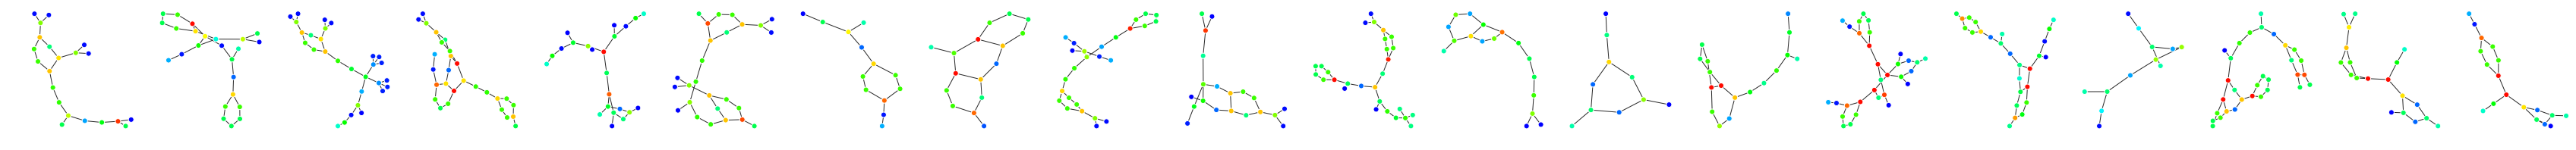

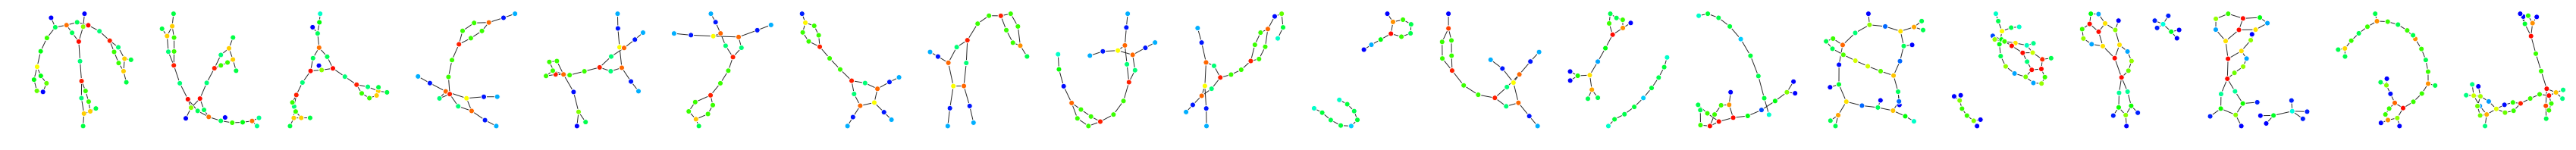

In [21]:
n_samples = 20
for label, indices in data_index_by_label.items():
    
    fix, axes = plt.subplots(1, n_samples, figsize=(3*n_samples, 3))
    for i, index in enumerate(indices[:n_samples]):
        pyt_geo_graph =  dataset[index]
       
        ax = axes[i]
        plot_graph(pyt_geo_graph, model, ax)

In [9]:
data_set_by_label = {l: torch.utils.data.Subset(dataset, i) for l, i in data_index_by_label.items()}
node_labels_by_label = {}
avg_node_labels_by_label = {}
sum_node_labels_by_label = {}
for label, ds in data_set_by_label.items():
    dl = torch.utils.data.DataLoader(ds, collate_fn=my_collate, batch_size=64)
    node_labels = []
    avg_node_labels = []
    sum_node_labels = []
    
    for batch in dl:
        if not hasattr(batch, 'node_lab'): 
            batch.node_lab = None

        node_filt = model(batch)  
        node_filt = node_filt.detach().tolist()
        node_labels += node_filt
        avg_node_labels += [np.mean(node_filt)]
        sum_node_labels += [sum(node_filt)]
        
    node_labels_by_label[label] = node_labels
    avg_node_labels_by_label[label] = avg_node_labels
    sum_node_labels_by_label[label] = sum_node_labels

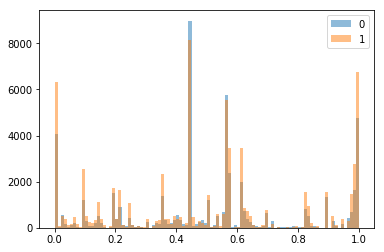

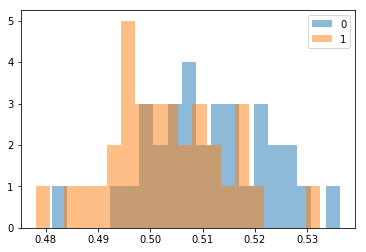

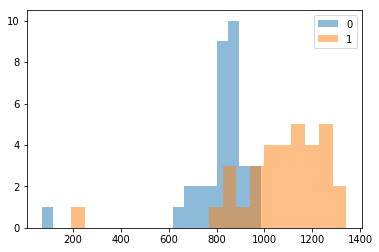

In [10]:
plt.figure()
for label, values in node_labels_by_label.items():
    plt.hist(values, bins=100, label=str(label), alpha=0.5)
plt.legend()

plt.figure()
for label, values in avg_node_labels_by_label.items():
    plt.hist(values, bins=20, label=str(label), alpha=0.5)
plt.legend()

plt.figure()
for label, values in sum_node_labels_by_label.items():
    plt.hist(values, bins=20, label=str(label), alpha=0.5)
plt.legend()